# Condition WGAN-GP

### 代入必要的包

In [79]:
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('C:/Users/Raphael/OneDrive/备份/桌面/大学生活和学习/教材/深度学习/Generative-Deep-Learning')
from utiles import display
device =  torch.device('cuda')

### 参数

In [80]:
IMAGE_SIZE = 64
CHANNELS = 3
CLASSES = 2
BATCH_SIZE = 128
Z_DIM = 32
LEARNING_RATE = 0.00005
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 20
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
LABEL = "Blond_Hair"
LABEL_DIR = "C:/Users/Raphael/OneDrive/备份/桌面/大学生活和学习/教材/深度学习/Generative-Deep-Learning/chapter_4/list_attr_celeba.csv"
IMG_DIR = "C:/Users/Raphael/OneDrive/备份/桌面/大学生活和学习/教材/深度学习/Generative-Deep-Learning/datas/img_align_celeba"

### 准备数据

In [81]:

class BHDataset(Dataset):
    def __init__(self, img_dir, label, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.attributes = pd.read_csv(LABEL_DIR)
        self.labels = self.attributes[label]
        # print(self.labels)
        self.int_labels = np.where(self.labels == 1, self.labels, 0)
        # print(self.int_labels)
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(self.int_labels[idx]).cuda()
        if self.transform:
            image = self.transform(image).cuda()
        return image, label

# 定义预处理函数
preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 255.0 - 127.5) / 127.5),
])

# 读入数据
train_data = BHDataset(img_dir=IMG_DIR, 
                                label=LABEL, 
                                transform=preprocess)

# 创建一个DataLoader实例
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

### 展示一些数据

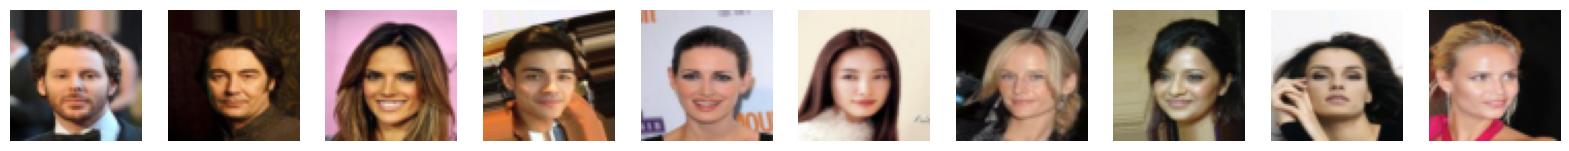

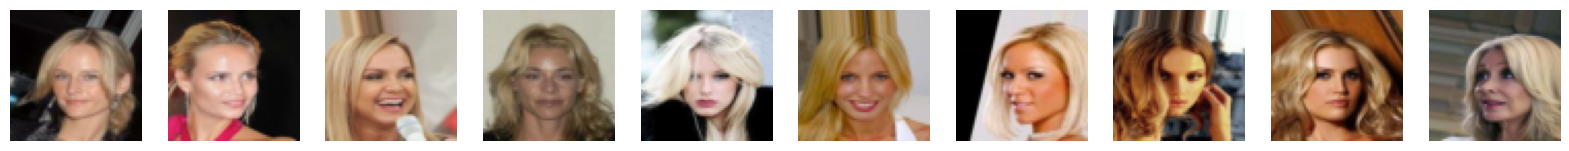

In [82]:
# 加载一些图像
data_iter = iter(train_loader)
images, labels = next(data_iter)
real_batch_images = images[0:10]
real_batch_label = labels[0:10]

real_batch_images = np.transpose(torch.squeeze(real_batch_images).cpu().numpy(),(0,2,3,1))

# 展示
display(real_batch_images, cmap="gray_r", as_type="float32")

# 加载并展示一些棕色头发的图像
blond_hair_images = images[labels == 1]
blond_hair_images = np.transpose(torch.squeeze(blond_hair_images[0:10]).cpu().numpy(),(0,2,3,1))
display(blond_hair_images, cmap="gray_r", as_type="float32")


## 建立模型

### 建立评价者模型

In [83]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.conv1 = nn.Conv2d(CHANNELS + 1, 64, kernel_size=4, stride=2, padding=1)
        self.leaky_relu1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.leaky_relu2 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout1 = nn.Dropout(0.3)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1)
        self.leaky_relu3 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout2 = nn.Dropout(0.3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1)
        self.leaky_relu4 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout3 = nn.Dropout(0.3)
        self.conv5 = nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0)
        self.flatten = nn.Flatten()

    def forward(self, critic_input, label_input):
        x = torch.cat([critic_input, label_input], dim=1)
        x = self.conv1(x)
        x = self.leaky_relu1(x)
        x = self.conv2(x)
        x = self.leaky_relu2(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = self.leaky_relu3(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = self.leaky_relu4(x)
        x = self.dropout3(x)
        x = self.conv5(x)
        x = self.flatten(x)
        return x

# 创建模型实例
critic = Critic().cuda()
print(critic)

Critic(
  (conv1): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (leaky_relu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (leaky_relu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (leaky_relu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (leaky_relu4): LeakyReLU(negative_slope=0.2, inplace=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (conv5): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [84]:
# 加载一些数据用于测试模型
test_data_iter = iter(train_loader)
test_images, test_labels = next(test_data_iter)
test_labels = torch.unsqueeze(torch.unsqueeze(torch.unsqueeze(test_labels, 1),1),1)
test_labels = test_labels.expand(-1,-1,IMAGE_SIZE,IMAGE_SIZE)
critic.eval()
with torch.no_grad():
    critic_output = critic(test_images, test_labels)
# print(critic_output)


### 生成器模型

In [85]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(Z_DIM + 1, 128)
        self.conv1 = nn.ConvTranspose2d(128, 128, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(128)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.ConvTranspose2d(64, CHANNELS, kernel_size=4, stride=2, padding=1, bias=False)

    def forward(self, generator_input, label_input):
        x = torch.cat([generator_input, label_input], dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), 128, 1, 1)
        x = self.leaky_relu(self.bn1(self.conv1(x)))
        x = self.leaky_relu(self.bn2(self.conv2(x)))
        x = self.leaky_relu(self.bn3(self.conv3(x)))
        x = self.leaky_relu(self.bn4(self.conv4(x)))
        x = torch.tanh(self.conv5(x))
        return x

# 创建模型实例
generator = Generator()
print(generator)

Generator(
  (fc): Linear(in_features=33, out_features=128, bias=True)
  (conv1): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (conv2): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [86]:
# 测试模型
generator_input = torch.randn(BATCH_SIZE, Z_DIM)
label_input = torch.randn(BATCH_SIZE, 1)

generator.eval()
with torch.no_grad():
    output = generator(generator_input, label_input)
print(output.shape)

torch.Size([128, 3, 64, 64])


### CGAN模型

In [95]:
class ConditionalWGAN(nn.Module):
    def __init__(self,critic,generator,latent_dim,critic_step,gp_weight):
        '''初始化模型'''
        super(ConditionalWGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_step = critic_step
        self.gp_weight = gp_weight
        self.c_optimizer = optim.Adam(self.critic.parameters(),lr=LEARNING_RATE,betas=(ADAM_BETA_1,ADAM_BETA_2))
        self.g_optimizer = optim.Adam(self.generator.parameters(),lr=LEARNING_RATE,betas=(ADAM_BETA_1,ADAM_BETA_2))
        self.generated_images = []

    def forward(self,real_images,labels):
        '''前向传播'''
        batch_size = real_images.shape[0]
        random_latent_vectors = torch.randn((batch_size, self.latent_dim)).cuda()

        generated_labels = torch.unsqueeze(labels,1)
        generated_images = self.generator(random_latent_vectors, generated_labels)

        critic_labels = torch.unsqueeze(torch.unsqueeze(torch.unsqueeze(labels, 1),1),1)
        critic_labels = critic_labels.expand(-1,-1,IMAGE_SIZE,IMAGE_SIZE)
        real_predictions = self.critic(real_images,critic_labels)
        fake_predictions = self.critic(generated_images,critic_labels)

        return real_predictions, fake_predictions, generated_images

    def gradient_penalty(self, real_images, generated_images, labels):
        '''计算梯度惩罚'''
        batch_size = real_images.shape[0]
        alpha = torch.rand((batch_size,1,1,1)).cuda()

        interpolated_images = real_images + alpha * (generated_images - real_images)
        interpolated_labels = torch.unsqueeze(torch.unsqueeze(torch.unsqueeze(labels, 1),1),1)
        interpolated_labels = interpolated_labels.expand(-1,-1,IMAGE_SIZE,IMAGE_SIZE)

        mixed_scores = self.critic(interpolated_images,interpolated_labels)

        gradient = torch.autograd.grad(
            inputs=[interpolated_images],
            outputs=[mixed_scores],
            grad_outputs=torch.ones_like(mixed_scores),
            create_graph=True,
            retain_graph=True,
        )[0]

        gradient = gradient.view(gradient.shape[0], -1)
        gradient_norm = gradient.norm(2, dim=1)
        gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
        return gradient_penalty

    def train(self,data_loader,epochs):
        '''训练模型'''
        self.generated_images = []

        for epoch in range(epochs):
            for i, (real_images, labels) in enumerate(data_loader):
                real_images = real_images.cuda()
                labels = labels.cuda()
                batch_size = real_images.shape[0]

                for j in range(CRITIC_STEPS):
                    real_predictions,fake_predictions,fake_images = self.forward(real_images,labels)

                    c_wass_loss = fake_predictions.mean() - real_predictions.mean()
                    c_gp = self.gradient_penalty(real_images, fake_images, labels)
                    c_loss = c_wass_loss + c_gp * GP_WEIGHT

                    self.c_optimizer.zero_grad()
                    c_loss.backward()
                    self.c_optimizer.step()

                real_predictions,fake_predictions,fake_images = self.forward(real_images,labels)
                g_loss = -fake_predictions.mean()


                self.g_optimizer.zero_grad()          
                g_loss.backward()
                self.g_optimizer.step()

                # if i % 5 == 0:
                #     print(f"Epoch {epoch}, Batch {i}, D loss: {c_loss.item()}, G loss: {g_loss.item()}")

            # 每5个epoch生成并保存10张图像
            if epoch % 5 == 0:
                with torch.no_grad():
                    generated_labels = torch.ones((10,1))
                    fake_images = self.generator(torch.randn(10, self.latent_dim).cuda(),generated_labels.cuda())
                    self.generated_images.append(fake_images)
                print(f"Epoch {epoch}, Batch {i}, D loss: {c_loss.item()}, G loss: {g_loss.item()}")

        # 训练结束后显示生成的图像
        for i, images in enumerate(self.generated_images):
            plt.figure(figsize=(10,10))
            for j, image in enumerate(images):
                plt.subplot(10, 10, j+1)
                plt.imshow(image.cpu().detach().numpy().transpose(1, 2, 0)* 127.5 + 127.5)
                plt.axis('off')
            plt.show()
    
    def test(self,labels = 0):
        '''测试模型'''
        labels = torch.ones((10,1))*labels
        fake_images = self.generator(torch.randn(10, self.latent_dim).cuda(), labels.cuda())
        
        fake_images = np.transpose(torch.squeeze(fake_images).cpu().detach().numpy(),(0,2,3,1))
        display(fake_images, cmap="gray_r", as_type="float32")
    
    def save(self, filepath = 'model/conditional_wgan.pth'):
        '''保存模型'''
        torch.save({
            'critic_state_dict': self.critic.state_dict(),
            'generator_state_dict': self.generator.state_dict(),
            'latent_dim': self.latent_dim,
            'critic_step': self.critic_step,
            'gp_weight': self.gp_weight,
            'c_optimizer_state_dict': self.c_optimizer.state_dict(),
            'g_optimizer_state_dict': self.g_optimizer.state_dict(),
            'generated_images': self.generated_images
        }, filepath)
    
    def load(self, filepath= 'model/conditional_wgan.pth'):
        '''加载模型'''
        checkpoint = torch.load(filepath)
        self.critic.load_state_dict(checkpoint['critic_state_dict'])
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.latent_dim = checkpoint['latent_dim']
        self.critic_step = checkpoint['critic_step']
        self.gp_weight = checkpoint['gp_weight']
        self.c_optimizer.load_state_dict(checkpoint['c_optimizer_state_dict'])
        self.g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        self.generated_images = checkpoint['generated_images']


## 开始训练

### 训练模型

Epoch 0, Batch 1582, D loss: -5.695387840270996, G loss: -12.021801948547363
Epoch 5, Batch 1582, D loss: -2.302513599395752, G loss: -27.93120765686035
Epoch 10, Batch 1582, D loss: -0.8832230567932129, G loss: 10.304349899291992
Epoch 15, Batch 1582, D loss: 0.7302800416946411, G loss: -20.132177352905273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

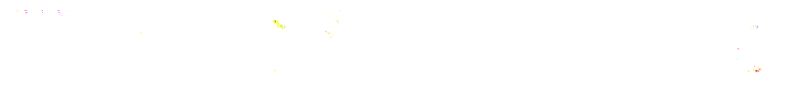

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

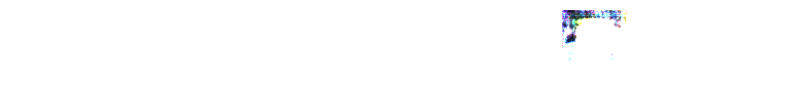

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

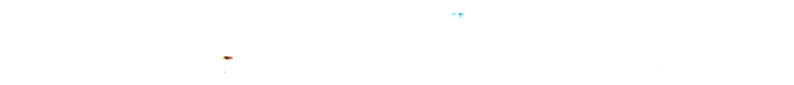

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

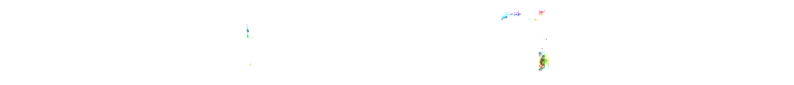

In [98]:
critic = Critic().cuda()
generator = Generator().cuda()
cgan = ConditionalWGAN(critic, generator, Z_DIM, CRITIC_STEPS, GP_WEIGHT)
cgan.train(train_loader, EPOCHS)


### 保存模型

In [99]:
cgan.save()
# cgan.load()


### 测试模型

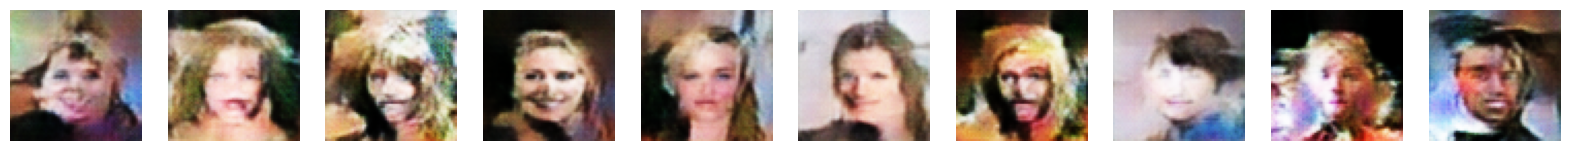

In [114]:
cgan.test(1)